In [1]:
#tests de données CSV déjà produites (indicateurs annuels)
CSVFILE="../3Mdata/trafic/comptages3M.csv"
import pandas as pd
import numpy as np
import geopandas as gpd

/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/tomm/comptages_3M/.venv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
MJA = pd.read_csv(CSVFILE)

In [3]:
MJA.columns

Index(['index', 'gid', 'annee', 'type_centrale', 'voie', 'commune',
       'hp_johvs_matin', 'hp_johvs_soir', 'mja_jo', 'mja_tcj', 'tir_tcj',
       'vtma_tcj', 'mja_pl_tcj', 'X', 'Y', 'geometry', 'libelle_centrale',
       'one_way', 'nb_voies', 'longueur', 'vmax'],
      dtype='object')

In [4]:
from matplotlib.figure import Figure
%matplotlib inline

def mpl_plot(x,variable,titre):
    fig = Figure()
    #FigureCanvas(fig) # not needed in mpl >= 3.1
    ax = fig.add_subplot()
    x.plot(ax=ax,kind='line',x='annee',y=variable,marker='+',title=titre)
    return fig

In [5]:
def moy_annuelle(variable='hp_johvs_soir', centrale='Feux complet_Montpellier_6511', view_fn=mpl_plot):
    avg = MJA[[variable,'annee']][MJA['nomgid']==centrale]
    titre=MJA[MJA['nomgid']==centrale].libelle_centrale.iloc[0]  # il n'y a pas de relation 1:1 entre libelle_centrale et gid, tant pis
    return view_fn(avg,variable,titre)

In [6]:
MJA['nomgid']=MJA['commune']+MJA['gid'].apply(lambda x: '_'+str(x))

In [7]:
MJA['nomgid']=MJA['type_centrale']+MJA['nomgid'].apply(lambda x: '_'+str(x))

In [8]:
MJA.columns

Index(['index', 'gid', 'annee', 'type_centrale', 'voie', 'commune',
       'hp_johvs_matin', 'hp_johvs_soir', 'mja_jo', 'mja_tcj', 'tir_tcj',
       'vtma_tcj', 'mja_pl_tcj', 'X', 'Y', 'geometry', 'libelle_centrale',
       'one_way', 'nb_voies', 'longueur', 'vmax', 'nomgid'],
      dtype='object')

In [19]:
#tt=MJA[['mja_jo','annee']][MJA['nomgid']=='Feux complet_Montpellier_6511']

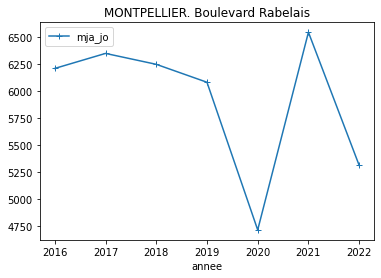

In [20]:
#moy_annuelle(variable='mja_jo', centrale='Feux Complet_Montpellier_6511', view_fn=mpl_plot)

## 1er essai de diagramme interactif

In [9]:
import panel as pn
pn.extension()

In [10]:
kw = dict(variable=['hp_johvs_matin', 'hp_johvs_soir', 'mja_jo', 'mja_tcj', 'tir_tcj','vtma_tcj', 'mja_pl_tcj'],centrale=sorted(list(set(MJA.nomgid.to_list()))))

In [11]:
i = pn.interact(moy_annuelle, **kw)

Row
    [0] Matplotlib(Figure, name='interactive00101')
    [1] Column
        [0] Markdown(str)
        [1] Select(name='variable', options=['hp_johvs_matin', ...], value='hp_johvs_soir')
        [2] Select(name='centrale', options=['Comptage ponctuel Velos_...], value='Comptage ponctuel V...)
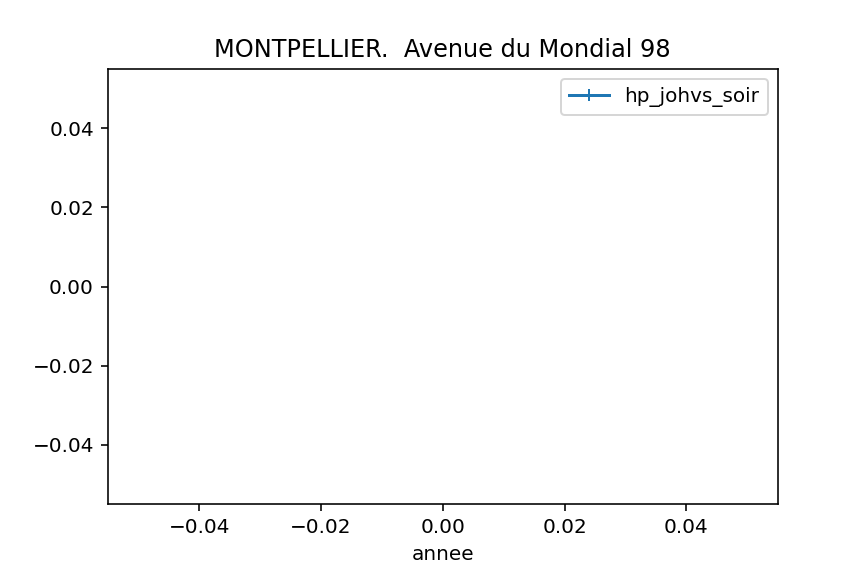

In [12]:
text = "<br>\nMoyennes annuelles 3M  \nChoississez la centrale et le type de mesures"

p = pn.Row(i[1][0], pn.Column(text, i[0][0], i[0][1]))
p

## Essai de carte des stations

In [13]:
import folium as fm

In [14]:
MJA.X.mean()

3.870392618693696

In [15]:
def get_map(lat=MJA.Y.mean(), long=MJA.X.mean(), zoom_start=13):
    return fm.Map(location=[lat,long], zoom_start=zoom_start)



In [16]:
map = get_map()


In [17]:
folium_nodes = [
        fm.Circle(
            radius=20,
            location=[MJA.Y.iloc[i],MJA.X.iloc[i]],
            color='green',
            fill=True,
            popup=MJA.libelle_centrale.iloc[i]
        )
        for i in range(MJA.shape[0])]
for f_node in folium_nodes:
    f_node.add_to(map)
        

In [18]:
#map
pn.panel(map, height=400)

Folium(Map, height=400)

## 2ème essai de diagramme interactif

In [19]:
import panel.widgets as pnw

Row
    [0] ParamFunction(function)
    [1] Column
        [0] Markdown(str)
        [1] RadioButtonGroup(button_type='success', name='variable', options=['hp_johvs_matin', ...], orientation='vertical', value='mja_jo')
        [2] Select(name='centrale', options=['Comptage ponctuel Velos_...], value='Feux Complet_Montpellier_...)
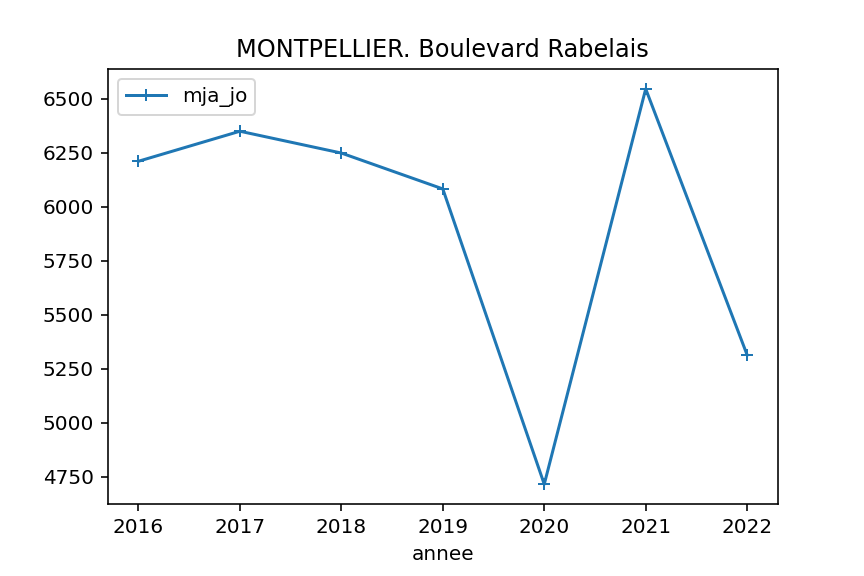

In [20]:
variable  = pnw.RadioButtonGroup(name='variable', value='mja_jo', orientation='vertical', button_type='success',
                                 options=['hp_johvs_matin', 'hp_johvs_soir', 'mja_jo', 'mja_tcj', 'tir_tcj','vtma_tcj', 'mja_pl_tcj'])
centrale  = pnw.Select(name='centrale', options=sorted(list(set(MJA.nomgid.to_list()))),value='Feux Complet_Montpellier_6511')

r_moy_annuelle = pn.bind(moy_annuelle, variable, centrale)

widgets   = pn.Column("<br>\n### Moyennes annuelles trafic 3M", variable, centrale)
show_moy = pn.Row(r_moy_annuelle, widgets)
show_moy